Variant: 3 (27) <br>
NN architecture: AlexNet <br>
Dataset: Cifar10 <br>
link to dataset: https://www.cs.toronto.edu/~kriz/cifar.html

## The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

### Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torchmetrics
import random
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Setting random number seed

In [3]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)

In [4]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator()
g_test = torch.Generator()
g_train.manual_seed(0)
g_test.manual_seed(1)

### Data read

In [5]:
# Calculate mean and std of test and train sets (255 - possible pixel value range)
traindata = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True).data / 255
testdata = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True).data / 255
mean_trn = traindata.mean(axis = (0,1,2)) 
std_trn = traindata.std(axis = (0,1,2))
mean_tst = testdata.mean(axis = (0,1,2)) 
std_tst = testdata.std(axis = (0,1,2))


# Create sequence of transformations: data -> resize to 256 x 256 -> 
#            -> (random horizontal flip for training data) -> tensor -> (tensor - mean) / std
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_trn, std_trn),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean_tst, std_tst),
])

# Number of images in each batch, reccomended to == 2^n
batch_size = 32

# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)
# Create a sampler, that provides an iterable over the trainset
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)
# Create a sampler, for testset
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g_test)

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 42899225.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In this lab work we don't perform hyperparameter tuning, as a result we split data only into train/test sets and therefore don't use validation set (test set plays his role).

### Data visualization

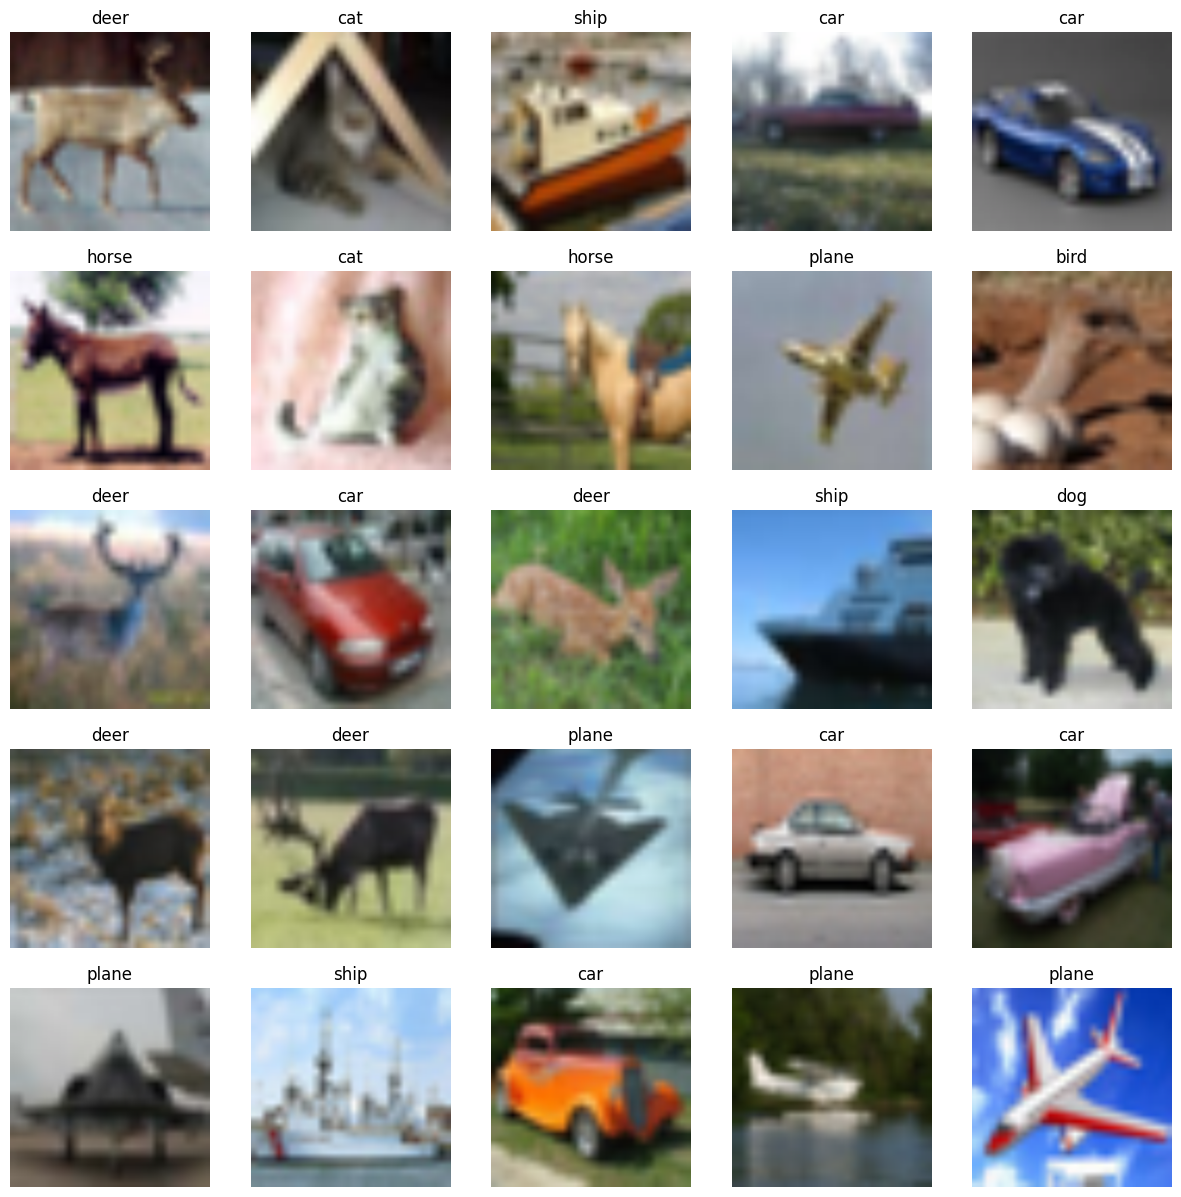

In [6]:
def imshow(img):
    # Unnormalize image
    img = img * std_trn[:, None, None] + mean_trn[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels in a grid 5x5
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(0, rows * cols):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i + 1)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

### Neural network setup

In [7]:
# Set up untrained AlexNet neural network with modified
# classification head to 10 classes, send this NN to GPU
alexnet = models.alexnet(num_classes=10).to(device)

# Set up loss criterion
criterion = nn.CrossEntropyLoss()
# Set up and send to GPU accuracy metric
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to(device)
# Set up stohastic gradient descent method of NN training with
# learning rate = 0.01
# momentum = 0.9
# (original values from scientific paper)
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

### Network training

In [8]:
# Set the number of epochs
epochs = 4
# Set the number of batches, after which info will be displayed
cycle = 400

# Create required arrays to store loss and accuracy
train_data_len = len(trainloader)
train_loss_arr = np.zeros(epochs)
test_data_len = len(testloader)
test_loss_arr = np.zeros(epochs)
test_accuracy_arr = np.zeros(epochs)

# Create training and testing loop
for epoch in range(epochs):
    print(f"Current epoch: {epoch + 1}\n-------")
    
    ##### Training #####
    train_loss = test_acc = test_loss = 0
    # Set network to train mode
    alexnet.train()
    
    # Add a loop through training batches
    for batch_num, (tr_inputs, tr_labels) in enumerate(trainloader):
        # Send data to cuda (preferably)
        tr_inputs = tr_inputs.to(device)
        tr_labels = tr_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet(tr_inputs).to(device)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss

        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if batch_num % cycle == 0 and batch_num != 0:
            print(f"Looked at {batch_num * batch_size} samples")
            print(f"Current train loss for batch: {loss}")
    ##### Training end #####
    
    ##### Testing #####
    # Set network to evaluation mode
    alexnet.eval()
    # Turn on inference mode (no autograd)
    with torch.inference_mode():
        for tst_inputs, tst_labels in testloader:
            # Send data to cuda (preferably)
            tst_inputs = tst_inputs.to(device)
            tst_labels = tst_labels.to(device)
            predictions = alexnet(tst_inputs).to(device)
            
            # Test loss and accuracy calculation
            test_loss += criterion(predictions, tst_labels)
            test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
    ##### Testing end #####
    
        # Save average (throughout the epoch) loss and accuracy
        train_loss_arr[epoch] = train_loss / train_data_len
        test_loss_arr[epoch] = test_loss / test_data_len
        test_accuracy_arr[epoch] = test_acc / test_data_len
    
    # Print out average loss and accuracy of this epoch
    print(f"\nAverage train loss: {train_loss_arr[epoch]:.5f}")
    print(f"Average test loss: {test_loss_arr[epoch]:.5f}, Average test acc: {test_accuracy_arr[epoch]:.2f}%\n")

Current epoch: 1
-------
Looked at 12800 samples
Current train loss for batch: 2.2986178398132324
Looked at 25600 samples
Current train loss for batch: 2.3025524616241455
Looked at 38400 samples
Current train loss for batch: 2.214437961578369

Average train loss: 2.24261
Average test loss: 1.97583, Average test acc: 0.29%

Current epoch: 2
-------
Looked at 12800 samples
Current train loss for batch: 1.8430495262145996
Looked at 25600 samples
Current train loss for batch: 1.8827046155929565
Looked at 38400 samples
Current train loss for batch: 1.7750179767608643

Average train loss: 1.71503
Average test loss: 1.52774, Average test acc: 0.43%

Current epoch: 3
-------
Looked at 12800 samples
Current train loss for batch: 1.2983227968215942
Looked at 25600 samples
Current train loss for batch: 1.4208163022994995
Looked at 38400 samples
Current train loss for batch: 1.4184082746505737

Average train loss: 1.44337
Average test loss: 1.31813, Average test acc: 0.52%

Current epoch: 4
------

### Weights saving

In [9]:
# Save weights to file 'AlexNet_CIFAR10_weights.pth'
torch.save(alexnet.state_dict(), 'AlexNet_CIFAR10_weights.pth')
# To load weigths:
# alexnet.load_state_dict(torch.load('AlexNet_CIFAR10_weights.pth'))
# alexnet.eval()

### Accuracy and loss plots

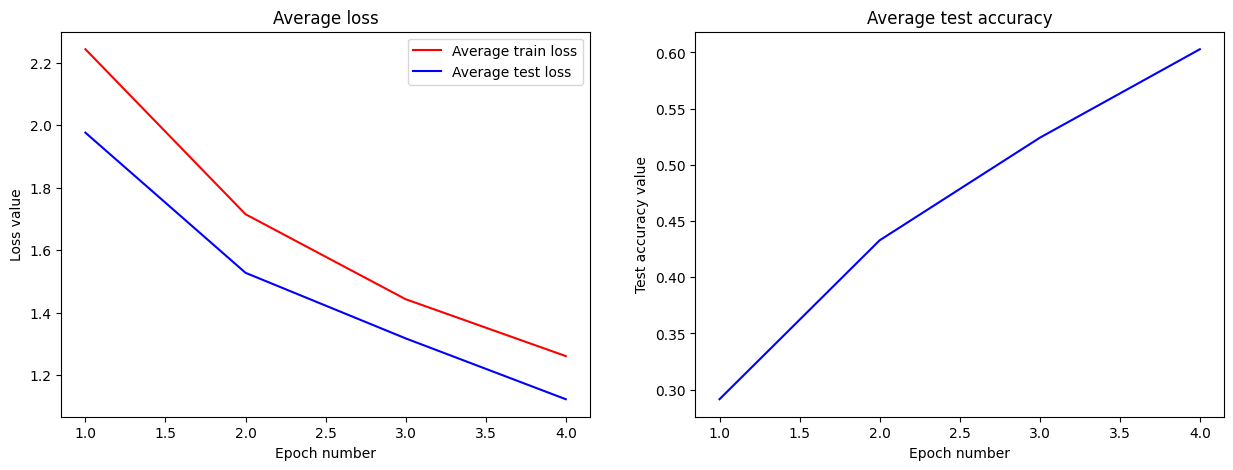

In [12]:
plt.figure(figsize = (15, 5))
epoch_arr = np.arange(1, epochs + 1)
plt.subplot(121)
plt.plot(epoch_arr, train_loss_arr, 'r', label='Average train loss')
plt.plot(epoch_arr, test_loss_arr,'b', label='Average test loss')
plt.title("Average loss")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(epoch_arr, test_accuracy_arr, 'b')
plt.title("Average test accuracy")
plt.xlabel("Epoch number")
plt.ylabel("Test accuracy value")
plt.show()

## Conclusions 
### As we see train and test loss were declining throughout the 4 epochs (as well as accuracy), this means that we stil haven't reached the optimum point (point, where train loss continue to decline, but test loss starts to rise). As a result it is advisable to continue training of the model, although, in this lab work, we will stop straining after epoch 4, due to limited computational resources. In the final run we got accuracy 60%, which is much better then accuracy of random classifier - 10%. In real situation we would also use validation test instead of test set, to tune hyperparameters of the model, and the test set would only be used to evaluate the performance of model after the training.
### In this work to ensure reproducibility we set numpy, random and pytorch seed, as well as forced cuDNN to deterministically select an algorithm. We also saved the weights of the final model, so it's possible to reproduce latest results.

In [ ]:
# OPTIONAL SECTION - WEIGHTs LOADING
alexnet.load_state_dict(torch.load('AlexNet_CIFAR10_weights.pth'))
alexnet.eval()

with torch.inference_mode():
    for tst_inputs, tst_labels in testloader:
        # Send data to cuda (preferably)
        tst_inputs = tst_inputs.to(device)
        tst_labels = tst_labels.to(device)
        predictions = alexnet(tst_inputs).to(device)
        
        # Test loss and accuracy calculation
        test_loss += criterion(predictions, tst_labels)
        test_acc += accuracy(predictions.argmax(dim=1), tst_labels)

    # Save average loss and accuracy
    test_loss_average = test_loss / test_data_len
    test_accuracy_average = test_acc / test_data_len
    
    # Print out average loss and accuracy
    print(f"Average test loss: {test_loss_average:.5f}, Average test acc: {test_accuracy_average:.2f}%\n")